In [44]:
# import library
import torch
import torch.nn as nn # 신경망
import torch.optim as optim # 최적화 알고리즘
import torch.nn.init as init # 텐서에 초기값 설정

from torch.autograd import Variable
import torchvision.datasets as datasets # 이미지 데이터셋 집합체
import torchvision.transforms as transforms # 이미지 변환 툴

from torch.utils.data import Dataset, DataLoader # 학습 및 배치로 모델에 넣어주기 위한 툴

import numpy as np
import matplotlib.pyplot as plt

In [59]:
# set gpu
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [45]:
# set hyperparameter
batch_size = 100
learning_rate = 0.0002
num_epoch = 10

In [46]:
train_dataset = datasets.MNIST(root="/home/bml_th/code/Data/", train=True, transform=transforms.ToTensor(), target_transform=None, download=False)
test_dataset = datasets.MNIST(root="/home/bml_th/code/Data/", train=False, transform=transforms.ToTensor(), target_transform=None, download=False)

In [47]:
# fashion mnist 데이터를 DataLoader에 전달
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 100)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 100)

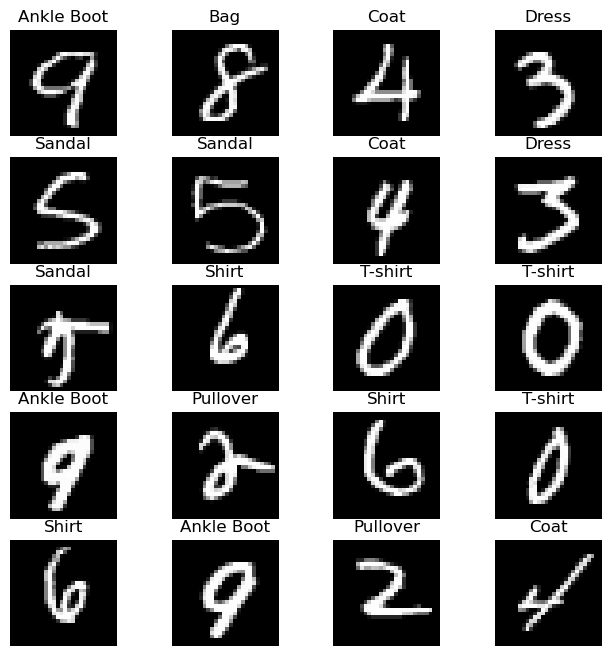

In [48]:
# 분류에 사용될 클래스 정의
labels_map = {0 : 'T-shirt', 1 : 'Trouser', 2: 'Pullover', 3:'Dress', 4:'Coat', 5:'Sandal',
              6: 'Shirt', 7: 'Sneaker', 8:'Bag', 9: 'Ankle Boot'}
fig = plt.figure(figsize = (8,8))
columns = 4
rows = 5
for i in range(1, columns*rows + 1):
    img_xy = np.random.randint(len(train_dataset))
    img = train_dataset[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap ='gray')
plt.show()

In [69]:
# CNN Model

class FashionCNN(nn.Module):
    def __init__(self):
        # super(): CNN class의 부모 class인 nn.Module을 초기화
        super(FashionCNN, self).__init__()
        self.layer1 = nn.Sequential(
            # [100,  1, 28, 28] -> [100, 32, 28, 28]
            nn.Conv2d(in_channels = 1, out_channels=32, kernel_size = 3, padding=1),
                      nn.BatchNorm2d(32),
                      nn.ReLU(),
                      # [100, 32, 28, 28] -> [100, 32, 14, 14]
                      nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            # [100, 32, 14, 14] -> [100, 64, 12, 12]
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # [100, 64, 12, 12] -> [100, 64, 6, 6]
            nn.MaxPool2d(2)
        )
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1) # out의 크기를 -> [batch_size, channels*height*width] 변경
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

        

In [70]:
learning_rate = 0.001
model = FashionCNN()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)


FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [72]:
# training
num_epoch = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epoch):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)

        outputs = model(train)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1

        if not (count % 50):
            total = 0
            correct = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(100, 1, 28, 28))
                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)

            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

Iteration: 500, Loss: 0.17519819736480713, Accuracy: 97.11000061035156%
Iteration: 1000, Loss: 0.14428351819515228, Accuracy: 96.72999572753906%
Iteration: 1500, Loss: 0.08495809882879257, Accuracy: 98.15999603271484%
Iteration: 2000, Loss: 0.02914438769221306, Accuracy: 98.82999420166016%
Iteration: 2500, Loss: 0.02247091569006443, Accuracy: 98.56999969482422%
Iteration: 3000, Loss: 0.198131263256073, Accuracy: 98.8699951171875%
